In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

from IPython.display import Audio

from module import config_lib, utils_lib

In [155]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            
            self.spectrogram_npy = '../data/processed/baseline/birdclef2025_melspec_5sec_256_256.npy'
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 524
        self.N_MELS = 128
        self.FMIN = 50
        self.FMAX = 14000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
            

In [156]:
cfg = DatasetConfig()
utils_lib.set_seed(cfg.seed)

In [157]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [158]:
train_label.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [159]:
taxonomy.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [160]:
df = pd.merge(train_label, taxonomy[["primary_label", "inat_taxon_id","class_name"]], on='primary_label', how='left')
df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta


In [161]:
print("\n欠損値:\n", df.isnull().sum())
print("\nデータ型:\n", df.dtypes)



欠損値:
 primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
inat_taxon_id         0
class_name            0
dtype: int64

データ型:
 primary_label        object
secondary_labels     object
type                 object
filename             object
collection           object
rating              float64
url                  object
latitude            float64
longitude           float64
scientific_name      object
common_name          object
author               object
license              object
inat_taxon_id         int64
class_name           object
dtype: object


In [162]:

# --- primary_label の分布 ---
print("\nprimary_label のユニーク数:", df['primary_label'].nunique())
print("\nprimary_label 上位10件:\n", df['primary_label'].value_counts().head(10))




primary_label のユニーク数: 206

primary_label 上位10件:
 primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64


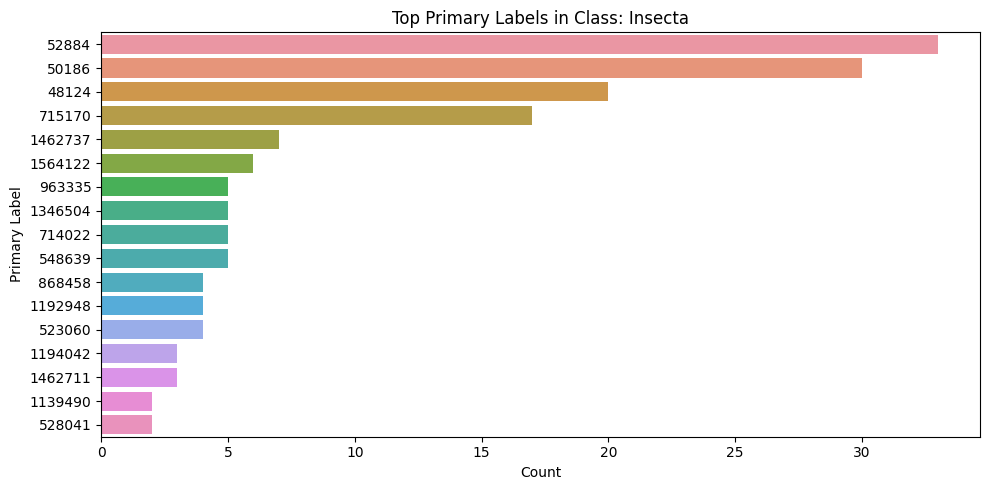

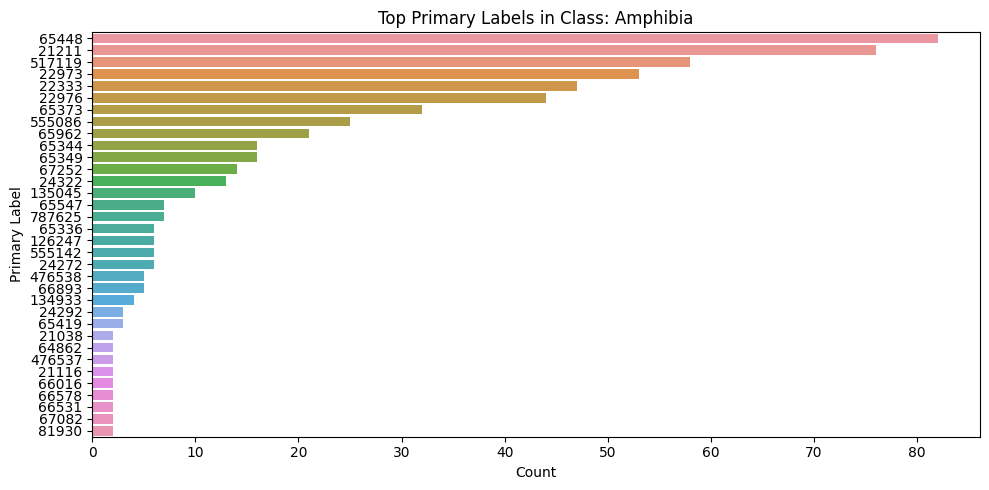

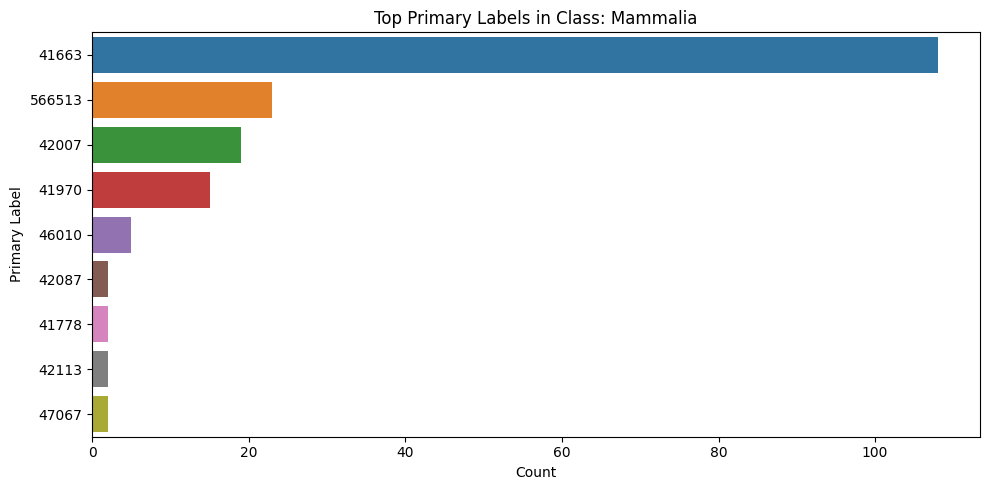

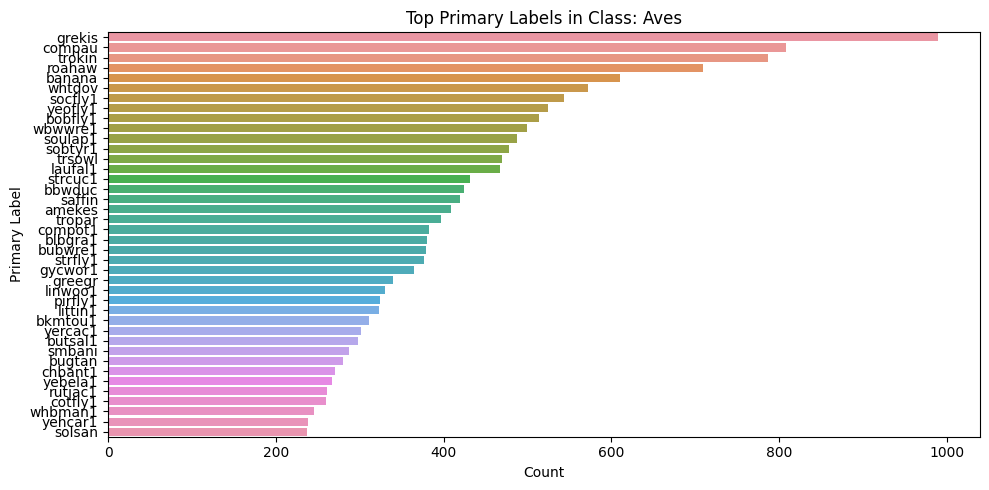

In [163]:
df[df["class_name"] == "Aves"].value_counts("primary_label").head(10)

# class_name ごとに primary_label の出現数トップ10を抽出
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").head(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()

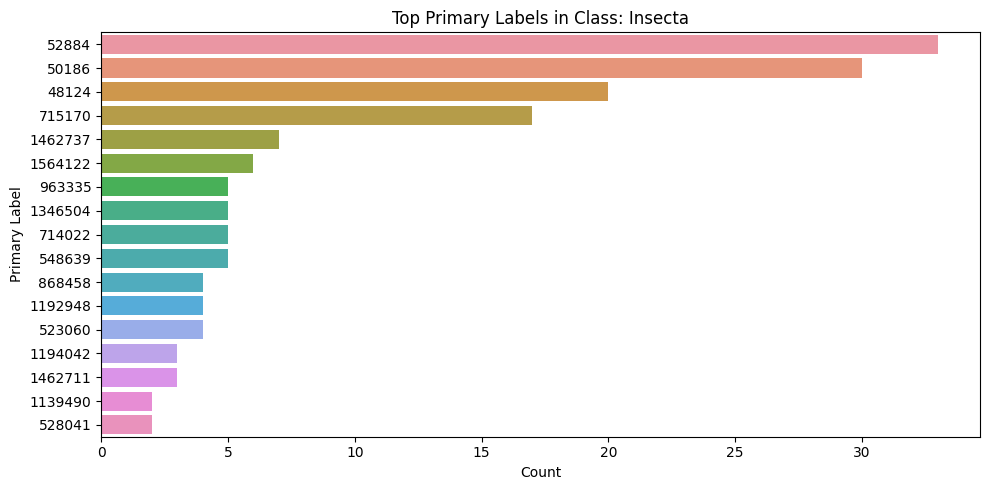

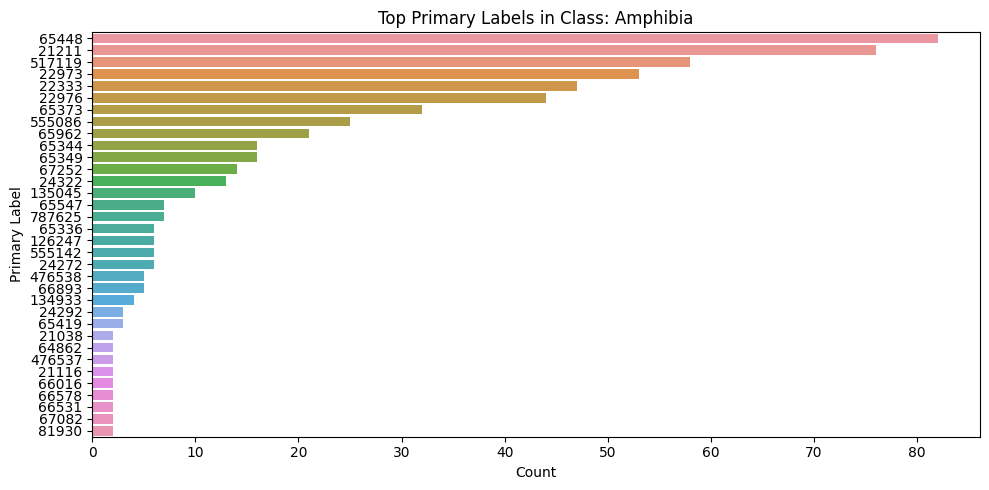

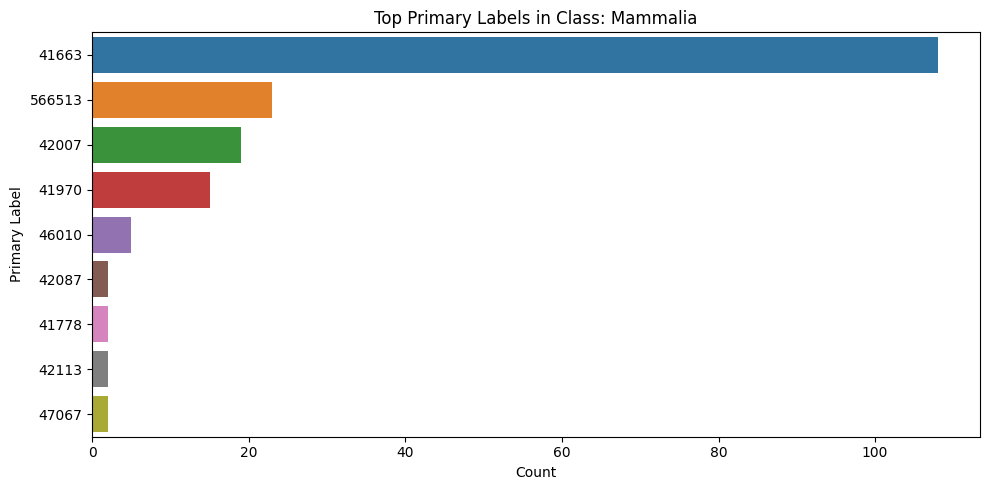

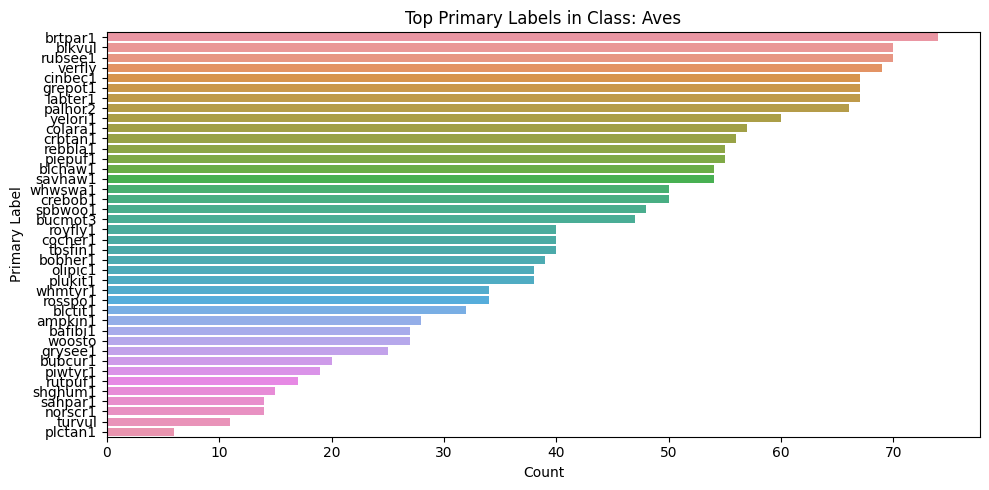

In [164]:

# 出現数ボトム40
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()


class_name ごとの primary_label のユニーク数:
   class_name  primary_label
1       Aves            146
0   Amphibia             34
2    Insecta             17
3   Mammalia              9


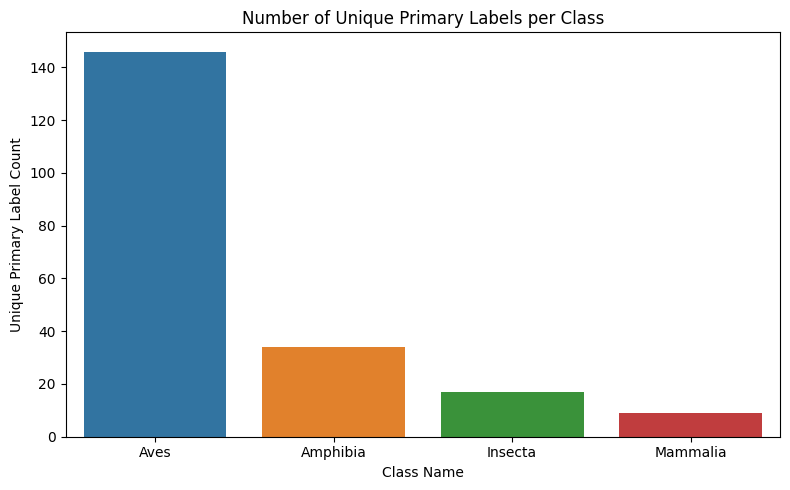

In [128]:
# 生物種ごとのラベル数
# class_name ごとの primary_label のユニーク数をカウント
label_counts = df.groupby('class_name')['primary_label'].nunique().reset_index()
label_counts = label_counts.sort_values('primary_label', ascending=False)

print("\nclass_name ごとの primary_label のユニーク数:\n", label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(data=label_counts, x='class_name', y='primary_label')
plt.title('Number of Unique Primary Labels per Class')
plt.xlabel('Class Name')
plt.ylabel('Unique Primary Label Count')
plt.tight_layout()
plt.show()


class_name の分布:
 class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


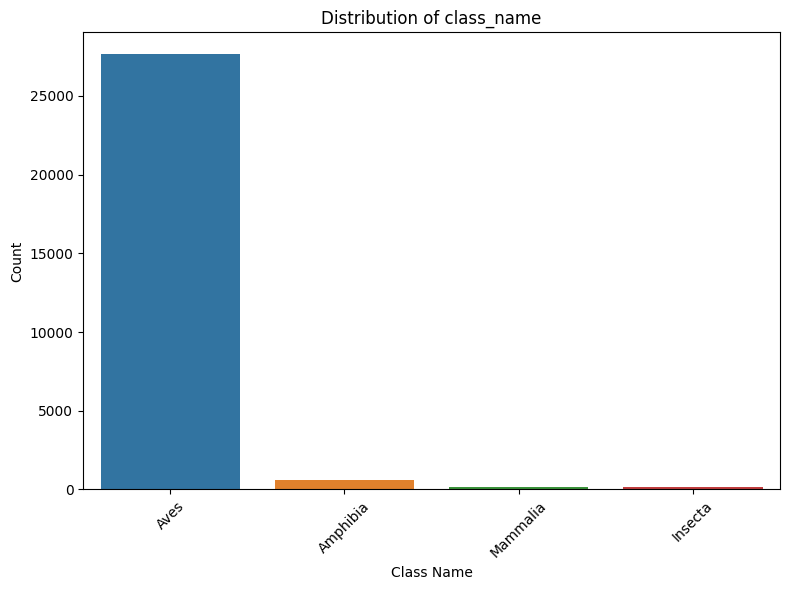

In [129]:
# --- class_name の分布 ---
print("\nclass_name の分布:\n", df['class_name'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class_name', order=df['class_name'].value_counts().index)
plt.title('Distribution of class_name')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


rating の分布:
 rating
0.0    7948
0.5      26
1.0     228
1.5      70
2.0     752
2.5     360
3.0    2886
3.5     895
4.0    7582
4.5    1261
5.0    6556
Name: count, dtype: int64


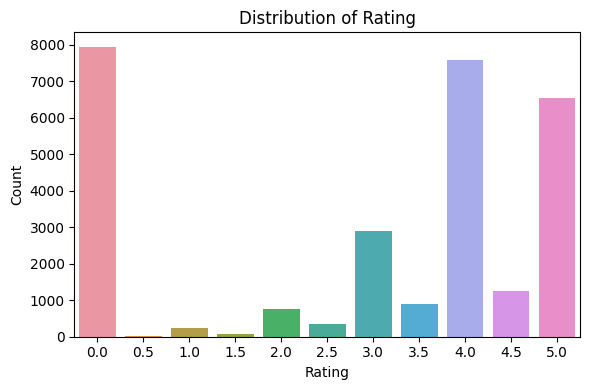

In [130]:

# --- rating の分布 ---
print("\nrating の分布:\n", df['rating'].value_counts().sort_index())


plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()))
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

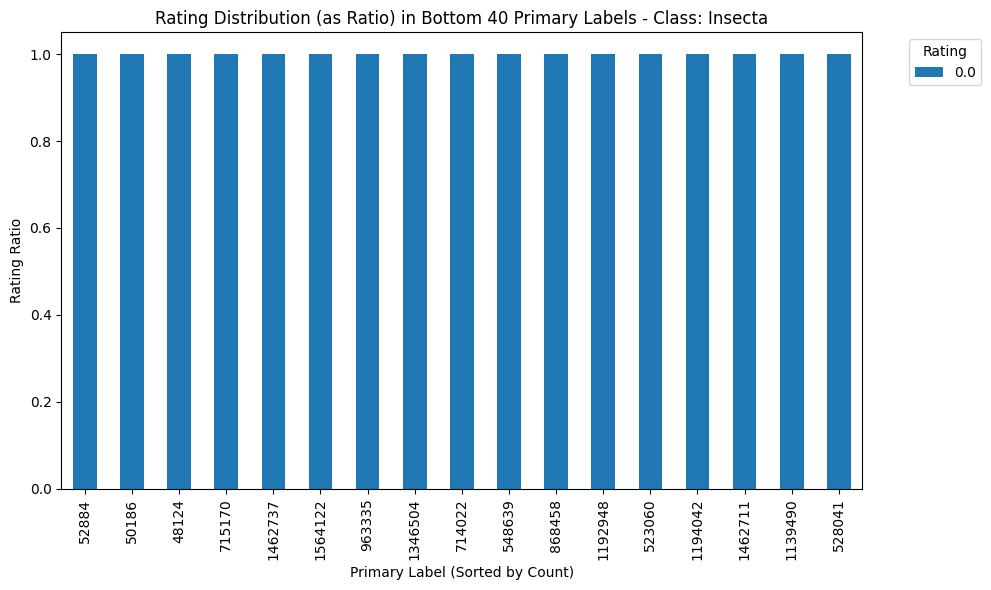

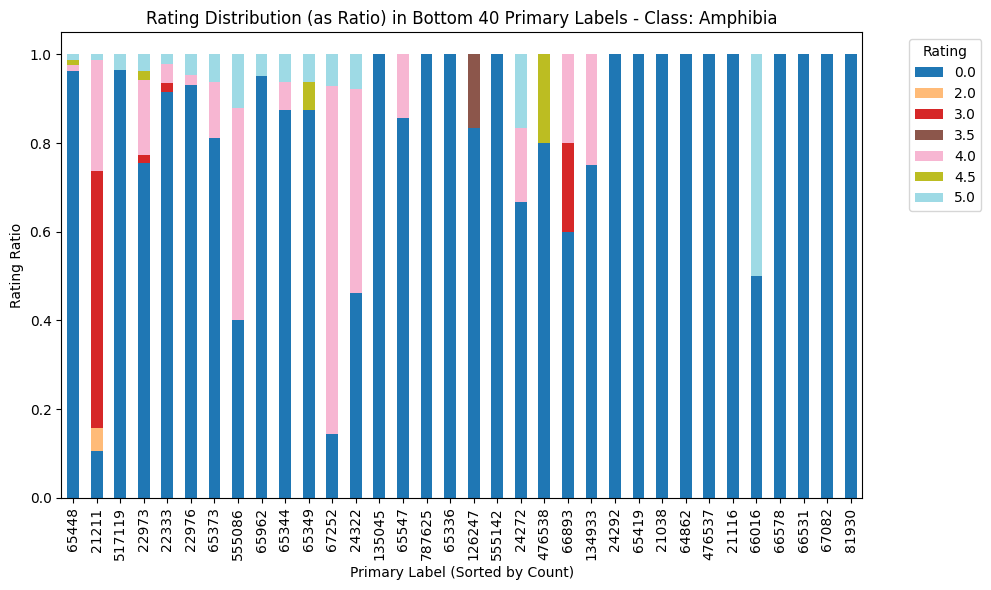

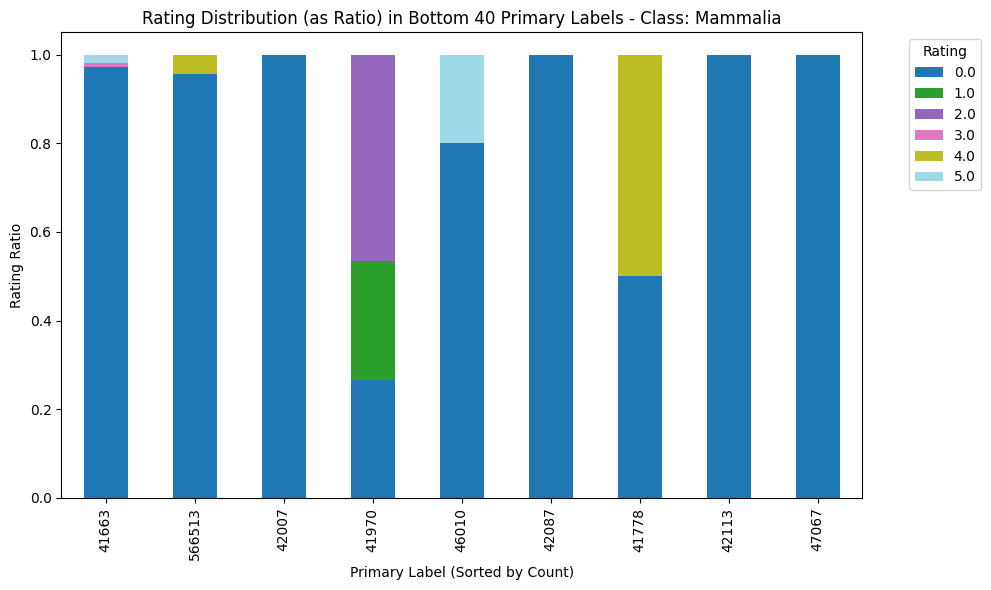

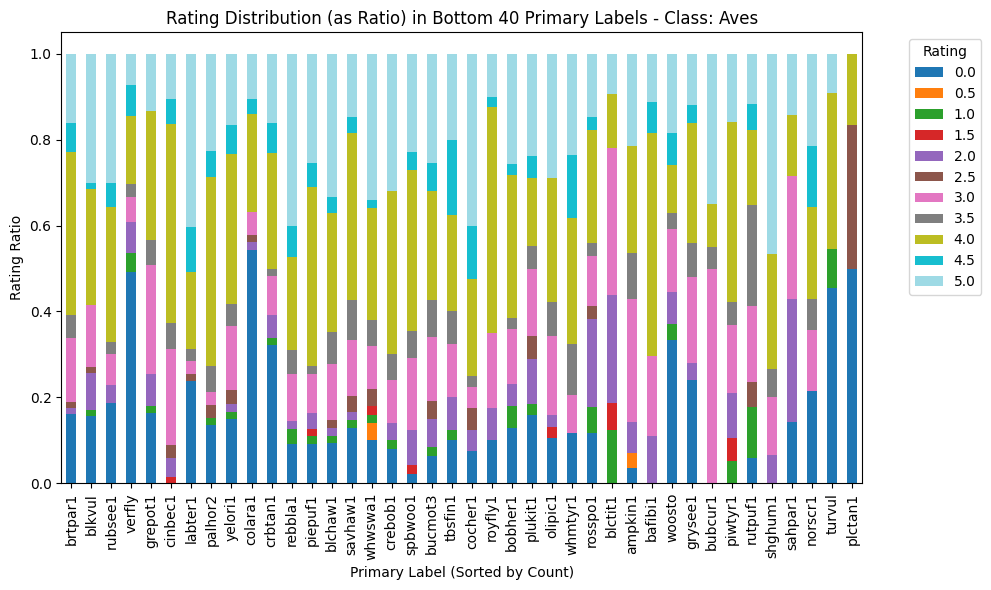

In [131]:
for class_name in df['class_name'].unique():
    # ボトム40の primary_label を抽出
    label_counts = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    bottom_labels = label_counts.index.tolist()

    # ボトム40に該当する行だけ抽出
    subset = df[(df["class_name"] == class_name) & (df["primary_label"].isin(bottom_labels))]

    # primary_label × rating のクロス集計（件数）
    pivot = pd.crosstab(subset['primary_label'], subset['rating'])

    # ❗primary_label の出現数で降順にソート
    pivot['total_count'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('total_count', ascending=False)
    pivot = pivot.drop(columns='total_count')  # 可視化には不要

    # 割合に変換
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)

    # 積み上げ棒グラフ
    pivot_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Rating Distribution (as Ratio) in Bottom 40 Primary Labels - Class: {class_name}')
    plt.xlabel('Primary Label (Sorted by Count)')
    plt.ylabel('Rating Ratio')
    plt.xticks(rotation=90)
    plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

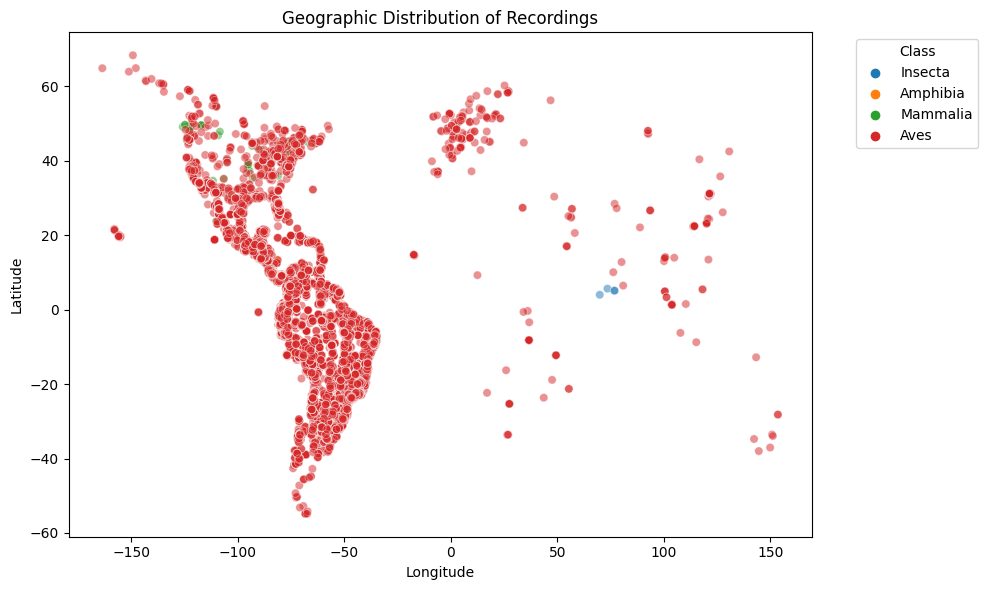

In [132]:
# --- 地理的分布の可視化 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='class_name', alpha=0.5)
plt.title('Geographic Distribution of Recordings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [133]:


def play_audio(filename, base_path):
    """
    音声ファイルを再生する。
    
    Parameters:
    - filename: メタデータに含まれるファイルパス（例: '1139490/CSA36385.ogg'）
    - base_path: self.train_datadir に相当するルートパス
    """
    filepath = os.path.join(base_path, filename)
    if os.path.exists(filepath):
        return Audio(filename=filepath)
    else:
        print("ファイルが見つかりません:", filepath)
        



In [134]:
# Insectaは最初に鳴いてる？その後人による解説

In [146]:
df

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,19003,Aves
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,19003,Aves
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,19003,Aves
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,19003,Aves


In [135]:
play_audio("52884/CSA36344.ogg", cfg.train_datadir)

In [102]:
df[df["class_name"] == "Insecta"].head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta


In [138]:
spec = np.load(cfg.spectrogram_npy, allow_pickle=True).item()

In [166]:
import librosa
def inverse_melspec(mel_spec_norm, config):
    """
    正規化された Mel スペクトログラム（0〜1）を元の波形に近づけて再生。
    
    Parameters:
    - mel_spec_norm: 正規化済みメルスペクトログラム（float32, shape: (128, T)）
    - config: 設定オブジェクト（DatasetConfig）

    Returns:
    - IPython.display.Audio オブジェクト
    """

    # ① 0〜1 の正規化を元に戻す
    mel_spec_db = mel_spec_norm * (0 - (-80)) + (-80)  # librosa.power_to_db の typical range: [-80, 0]

    # ② dB → power
    mel_power = librosa.db_to_power(mel_spec_db)

    # ③ mel → STFT
    stft = librosa.feature.inverse.mel_to_stft(
    M=mel_power,
    sr=config.FS,
    n_fft=config.N_FFT,
    power=2.0,
    fmin=config.FMIN,
    fmax=config.FMAX
    )

    # ④ Griffin-Lim で波形復元
    waveform = librosa.griffinlim(
        stft,
        n_iter=32,
        hop_length=config.HOP_LENGTH,
        win_length=config.N_FFT
    )

    return Audio(waveform, rate=config.FS)

In [167]:
# 例: spec["1139490-CSA36385"] がメルスペクトログラム
mel_spec = spec["ywcpar-iNat922688"]  # shape: (128, T)

# 再生
inverse_melspec(mel_spec, cfg)

/opt/conda/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [147]:
play_audio("ywcpar/iNat922688.ogg", cfg.train_datadir)